In [8]:
import sys
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt

parent_dir = Path.cwd().parent
project_src = f"{parent_dir}/src"

if str(project_src) not in sys.path:
    sys.path.append(str(project_src))

In [10]:
from config import settings
from utils.filesystem_utils import DatasetLoader

In [11]:
df = DatasetLoader.handle(str(settings.data_path / "creditcard.csv.zip"))

In [12]:
df.shape

(284807, 31)

### 📄 Feature Descriptions

| Column   | Description                                                                 |
|----------|-----------------------------------------------------------------------------|
| `Time`   | Number of seconds elapsed between this transaction and the first transaction in the dataset. |
| `Amount` | Transaction amount in Euros.                                                |
| `Class`  | Target variable: `0` for legitimate transactions, `1` for fraudulent ones.  |
| `V1` to `V28` | Numerical features resulting from a PCA transformation for confidentiality reasons. The original features have been anonymized. |

In [13]:
# Very unbalanced classes
df.select("Class").to_series().value_counts()

Class,count
i64,u32
0,284315
1,492


In [14]:
# Noise
print("Nulls", df.null_count())
print("Duplicates", df.is_duplicated().sum())

Nulls shape: (1, 31)
┌──────┬─────┬─────┬─────┬───┬─────┬─────┬────────┬───────┐
│ Time ┆ V1  ┆ V2  ┆ V3  ┆ … ┆ V27 ┆ V28 ┆ Amount ┆ Class │
│ ---  ┆ --- ┆ --- ┆ --- ┆   ┆ --- ┆ --- ┆ ---    ┆ ---   │
│ u32  ┆ u32 ┆ u32 ┆ u32 ┆   ┆ u32 ┆ u32 ┆ u32    ┆ u32   │
╞══════╪═════╪═════╪═════╪═══╪═════╪═════╪════════╪═══════╡
│ 0    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0   ┆ 0   ┆ 0      ┆ 0     │
└──────┴─────┴─────┴─────┴───┴─────┴─────┴────────┴───────┘
Duplicates 1854


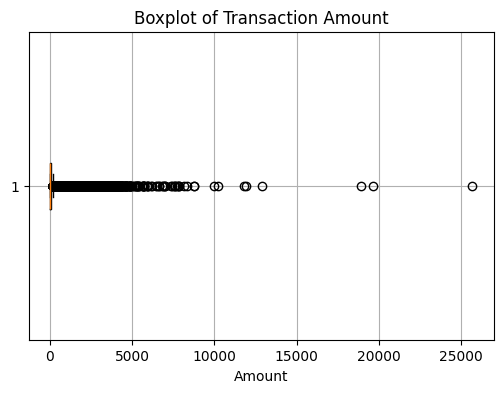

In [15]:
# The distribution is heavily right-skewed: most amounts are small, but a few are very large.
# Outliers are very prominent and should be taken into account during modeling

amount_series = df.select("Amount").to_pandas()

plt.figure(figsize=(6, 4))
plt.boxplot(amount_series["Amount"], vert=False)
plt.title("Boxplot of Transaction Amount")
plt.xlabel("Amount")
plt.grid(True)
plt.show()

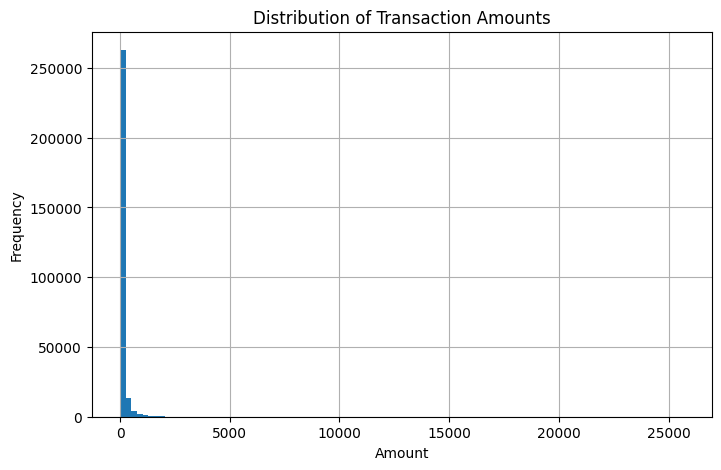

In [16]:
amount_np = df.select("Amount").to_numpy().flatten()

plt.figure(figsize=(8, 5))
plt.hist(amount_np, bins=100)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [17]:
# to hours
df = df.with_columns(
    (pl.col("Time") / 3600).alias("Time_hours")
)

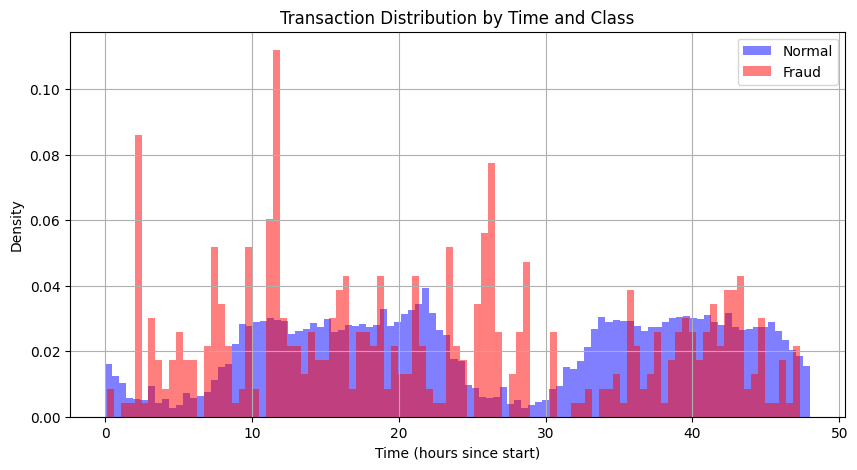

In [18]:
# Normal transactions follow a relatively stable and repetitive pattern.
# Fraudulent transactions are more dispersed and do not clearly follow the pattern of normal ones.
# Frauds appear to be concentrated at specific times.

df_pandas = df.to_pandas()

fraud = df_pandas[df_pandas["Class"] == 1]
normal = df_pandas[df_pandas["Class"] == 0]

plt.figure(figsize=(10, 5))
plt.hist(normal["Time_hours"], bins=100, alpha=0.5, label="Normal", color="blue", density=True)
plt.hist(fraud["Time_hours"], bins=100, alpha=0.5, label="Fraud", color="red", density=True)

plt.xlabel("Time (hours since start)")
plt.ylabel("Density")
plt.title("Transaction Distribution by Time and Class")
plt.legend()
plt.grid(True)
plt.show()

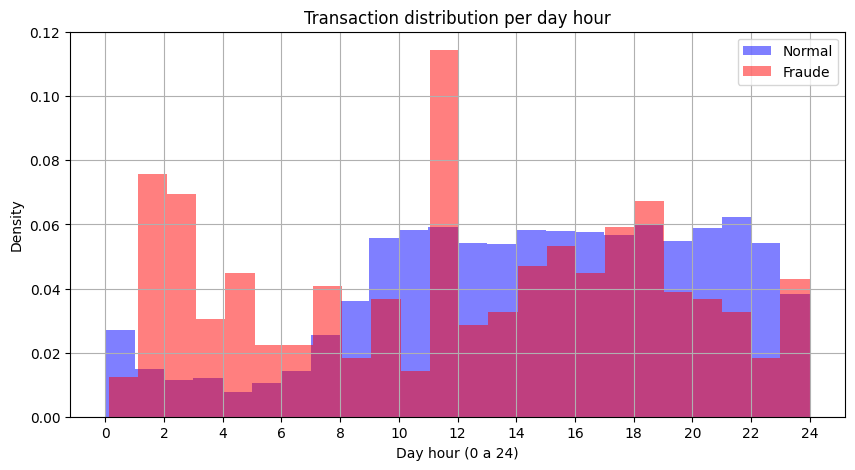

In [19]:
df_pandas = df.to_pandas()

df_pandas["Time_hours"] = df["Time"] / 3600

df_pandas["Hour_of_day"] = df["Time_hours"] % 24

fraud = df_pandas[df_pandas["Class"] == 1]
normal = df_pandas[df_pandas["Class"] == 0]

plt.figure(figsize=(10, 5))
plt.hist(normal["Hour_of_day"], bins=24, alpha=0.5, label="Normal", color="blue", density=True)
plt.hist(fraud["Hour_of_day"], bins=24, alpha=0.5, label="Fraude", color="red", density=True)

plt.xlabel("Day hour (0 a 24)")
plt.ylabel("Density")
plt.title("Transaction distribution per day hour")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 25, 2))
plt.show()

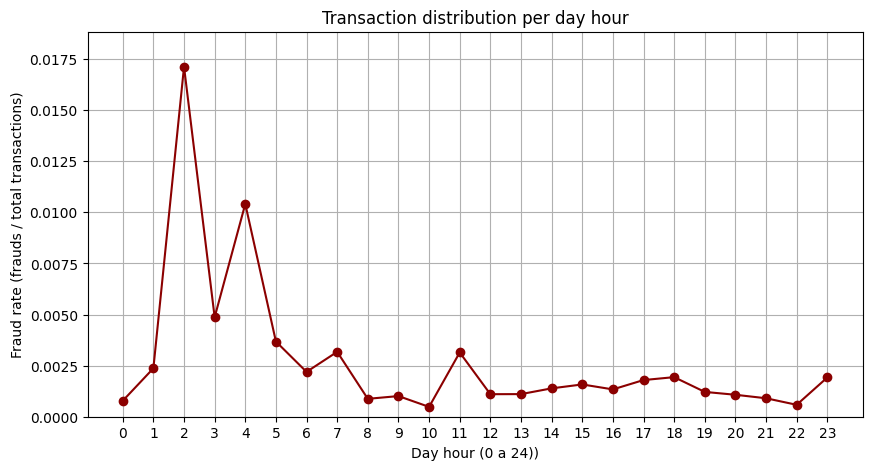

In [20]:
# In proportion there are more frauds in the early morning

df_pandas = df.to_pandas()

df_pandas["Time_hours"] = df_pandas["Time"] / 3600
df_pandas["Hour_of_day"] = df_pandas["Time_hours"] % 24

df_pandas["Hour_of_day_int"] = df_pandas["Hour_of_day"].astype(int)

hourly_counts = df_pandas.groupby("Hour_of_day_int")["Class"].count()
hourly_frauds = df_pandas.groupby("Hour_of_day_int")["Class"].sum()

fraud_rate = (hourly_frauds / hourly_counts).fillna(0)

plt.figure(figsize=(10, 5))
plt.plot(fraud_rate.index, fraud_rate.values, marker="o", linestyle="-", color="darkred")
plt.title("Transaction distribution per day hour")
plt.xlabel("Day hour (0 a 24))")
plt.ylabel("Fraud rate (frauds / total transactions)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.ylim(0, fraud_rate.max() * 1.1)
plt.show()